In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor 
from scipy.stats import skew, kurtosis
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from lightgbm import plot_importance
from scipy.stats import entropy
from scipy.signal import welch
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler

### Feature Engineering

In [2]:
def get_freq_features(x,col):
    
    fft_vals = np.abs(fft(x))
    fft_freqs = np.fft.fftfreq(len(fft_vals))
    dominant_freq = fft_freqs[np.argmax(fft_vals)]

    freqs, psd = welch(x)
    psd_norm = psd / np.sum(psd)

    spectral_entropy = entropy(psd_norm)
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * psd) / np.sum(psd))
    spectral_rolloff = freqs[np.where(np.cumsum(psd) >= 0.85 * np.sum(psd))[0][0]]

    feature_dict = {}

    feature_dict[col+'_fft_mean'] = np.mean(fft_vals)
    feature_dict[col+'_fft_min'] = np.min(fft_vals)
    feature_dict[col+'_fft_max'] = np.max(fft_vals)
    feature_dict[col+'_fft_std'] = np.std(fft_vals)
    feature_dict[col+'_fft_range'] = np.max(fft_vals)-np.min(fft_vals)

    feature_dict[col+'_psd_mean'] = np.mean(psd)
    feature_dict[col+'_psd_min'] = np.min(psd)
    feature_dict[col+'_psd_max'] = np.max(psd)
    feature_dict[col+'_psd_std'] = np.std(psd)
    feature_dict[col+'_psd_range'] = np.max(psd)-np.min(psd)

    feature_dict[col+'_dominant_freq'] = dominant_freq
    feature_dict[col+'_spectral_entropy'] = spectral_entropy
    feature_dict[col+'_spectral_centroid'] = spectral_centroid
    feature_dict[col+'_spectral_bandwidth'] = spectral_bandwidth
    feature_dict[col+'_spectral_rolloff'] = spectral_rolloff

    return feature_dict


def get_windows(x,n_parts):
    step_size = int(np.ceil(len(x)/n_parts))
    window_list = []
    for idx in np.arange(0,len(x),step=step_size):
        window_list.append(x[idx:idx+step_size])
    return window_list

In [3]:
data_pd = pd.read_csv("data/data_trimmed_merged.csv",index_col=0)

data_pd['genre_coded'] = data_pd['genre'].astype('category').cat.codes

sensor_cols = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','mag_x','mag_y','mag_z']

data_list = data_pd.groupby(['subject_id','label','genre_coded'])[sensor_cols].agg(list).reset_index()

for sens in ['acc','gy','mag']:
    data_list['magnitude_'+sens] = data_list.apply(lambda x: np.sqrt(np.array(x[sens+'_x'])**2+np.array(x[sens+'_y'])**2+np.array(x[sens+'_z'])**2),axis=1)
    sensor_cols.append('magnitude_'+sens)

In [4]:
for col in sensor_cols:
    data_list[col] = data_list[col].apply(lambda x: get_windows(x,1))

data_list = data_list.explode(sensor_cols).reset_index().drop('index',axis=1)

In [5]:
freq_features = []
cols_tmp = sensor_cols.copy()

for col in cols_tmp:
    data_list[col+'_diff1'] = data_list[col].apply(lambda x: np.roll(x,-1)[:-1] - np.array(x)[:-1])
    data_list[col+'_diff2'] = data_list[col+'_diff1'].apply(lambda x: np.roll(x,-1)[:-1] - np.array(x)[:-1])
    sensor_cols += [col+'_diff1',col+'_diff2']
    freq_features_pd = pd.DataFrame(data_list[col].apply(lambda x: get_freq_features(x,col)).tolist())
    freq_features.append(freq_features_pd)

data_list = pd.concat([data_list]+freq_features,axis=1)

In [ ]:
for col in sensor_cols:
    data_list[col+'_mean'] = data_list[col].apply(lambda x: np.mean(x))
    data_list[col+'_std'] = data_list[col].apply(lambda x: np.std(x))
    data_list[col+'_min'] = data_list[col].apply(lambda x: np.min(x))
    data_list[col+'_max'] = data_list[col].apply(lambda x: np.max(x))
    data_list[col+'_range'] = data_list[col].apply(lambda x: np.max(x)-np.min(x))
    data_list[col+'_skew'] = data_list[col].apply(lambda x: skew(x))
    data_list[col+'_kurtosis'] = data_list[col].apply(lambda x: kurtosis(x))

In [7]:
model_data = data_list.drop(sensor_cols,axis=1)

subject_ids = data_list.subject_id.unique()

### LightGBM Model

In [8]:
def objective(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 200, step=10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200,step=10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 10),
        'max_depth': trial.suggest_int('max_depth', 8, 32),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25,step=0.01),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10, step=1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10, step=1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0,step=0.05),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0,step=0.05),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 0.1,step=0.01)
    }

    feature_cols = model_data.drop(['subject_id','label','genre_coded'],axis=1).columns
    selected_features = []
    for col in feature_cols:
        if trial.suggest_int(col, 0, 1) == 1:
            selected_features.append(col)
    if len(selected_features) == 0:
        selected_features = [feature_cols[0]]


    cv_scores = []

    for val_subject in subject_ids:

        model = LGBMClassifier(objective='multiclass',num_class=4,**param_grid,verbose=-1)

        cv_train = model_data[model_data['subject_id']!=val_subject]
        cv_test = model_data[model_data['subject_id']==val_subject]

        X_train = cv_train[selected_features]
        X_test = cv_test[selected_features]
        y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        #score = f1_score(preds,y_test,average='weighted')
        score = accuracy_score(preds,y_test)
        cv_scores.append(score)
    
    
    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=200)

In [10]:
#210
#selected_cols_lgb = ['acc_x_fft_min','acc_x_psd_std','acc_x_psd_range','acc_x_dominant_freq','acc_x_spectral_centroid','acc_y_fft_std','acc_y_psd_mean','acc_y_psd_min','acc_y_psd_max','acc_y_psd_std','acc_y_dominant_freq','acc_y_spectral_entropy','acc_y_spectral_centroid','acc_y_spectral_bandwidth','acc_z_fft_mean','acc_z_fft_min','acc_z_fft_max','acc_z_fft_std','acc_z_fft_range','acc_z_psd_mean','acc_z_psd_std','acc_z_dominant_freq','acc_z_spectral_entropy','acc_z_spectral_centroid','acc_z_spectral_rolloff','gy_x_fft_mean','gy_x_fft_max','gy_x_fft_range','gy_x_psd_std','gy_x_psd_range','gy_x_spectral_entropy','gy_x_spectral_centroid','gy_x_spectral_bandwidth','gy_x_spectral_rolloff','gy_y_fft_mean','gy_y_fft_max','gy_y_fft_std','gy_y_fft_range','gy_y_psd_mean','gy_y_psd_min','gy_y_psd_std','gy_y_psd_range','gy_y_dominant_freq','gy_y_spectral_bandwidth','gy_z_fft_mean','gy_z_fft_max','gy_z_fft_std','gy_z_psd_min','gy_z_psd_max','gy_z_psd_range','gy_z_spectral_entropy','gy_z_spectral_centroid','gy_z_spectral_rolloff','mag_x_fft_max','mag_x_fft_range','mag_x_spectral_centroid','mag_y_fft_mean','mag_y_fft_min','mag_y_fft_max','mag_y_fft_std','mag_y_fft_range','mag_y_psd_std','mag_z_fft_min','mag_z_fft_max','mag_z_fft_std','mag_z_fft_range','mag_z_psd_mean','mag_z_psd_min','mag_z_dominant_freq','mag_z_spectral_centroid','mag_z_spectral_bandwidth','magnitude_acc_fft_mean','magnitude_acc_fft_min','magnitude_acc_fft_std','magnitude_acc_spectral_entropy','magnitude_acc_spectral_bandwidth','magnitude_acc_spectral_rolloff','magnitude_gy_fft_min','magnitude_gy_fft_std','magnitude_gy_fft_range','magnitude_gy_psd_min','magnitude_gy_psd_std','magnitude_gy_psd_range','magnitude_gy_spectral_centroid','magnitude_gy_spectral_bandwidth','magnitude_gy_spectral_rolloff','magnitude_mag_fft_max','magnitude_mag_fft_std','magnitude_mag_psd_mean','magnitude_mag_psd_std','magnitude_mag_dominant_freq','magnitude_mag_spectral_centroid','acc_x_std','acc_x_max','acc_x_range','acc_x_skew','acc_x_kurtosis','acc_y_skew','acc_y_kurtosis','acc_z_std','acc_z_max','acc_z_range','acc_z_skew','acc_z_kurtosis','gy_x_mean','gy_x_std','gy_x_skew','gy_y_std','gy_y_min','gy_y_range','gy_y_skew','gy_y_kurtosis','gy_z_mean','gy_z_min','gy_z_max','gy_z_range','gy_z_skew','gy_z_kurtosis','mag_x_std','mag_x_min','mag_x_max','mag_x_range','mag_x_skew','mag_x_kurtosis','mag_y_mean','mag_y_std','mag_y_min','mag_y_skew','mag_z_skew','mag_z_kurtosis','magnitude_acc_mean','magnitude_acc_max','magnitude_acc_range','magnitude_gy_mean','magnitude_gy_std','magnitude_gy_min','magnitude_gy_kurtosis','magnitude_mag_std','magnitude_mag_min','magnitude_mag_range','acc_x_diff1_skew','acc_x_diff2_min','acc_x_diff2_max','acc_x_diff2_range','acc_x_diff2_kurtosis','acc_y_diff1_mean','acc_y_diff1_max','acc_y_diff1_range','acc_y_diff1_kurtosis','acc_y_diff2_min','acc_y_diff2_range','acc_y_diff2_skew','acc_z_diff2_mean','acc_z_diff2_min','acc_z_diff2_kurtosis','gy_x_diff1_min','gy_x_diff1_max','gy_x_diff1_skew','gy_x_diff2_mean','gy_x_diff2_std','gy_x_diff2_max','gy_x_diff2_range','gy_x_diff2_kurtosis','gy_y_diff1_max','gy_y_diff1_range','gy_y_diff1_skew','gy_y_diff2_mean','gy_y_diff2_std','gy_y_diff2_range','gy_z_diff1_mean','gy_z_diff1_min','gy_z_diff1_range','gy_z_diff1_skew','gy_z_diff2_mean','gy_z_diff2_std','gy_z_diff2_min','mag_x_diff1_mean','mag_x_diff1_min','mag_x_diff1_max','mag_x_diff1_skew','mag_x_diff2_range','mag_x_diff2_skew','mag_y_diff1_mean','mag_y_diff1_range','mag_y_diff2_mean','mag_y_diff2_min','mag_y_diff2_max','mag_y_diff2_kurtosis','mag_z_diff1_mean','mag_z_diff1_range','mag_z_diff1_skew','mag_z_diff2_std','mag_z_diff2_skew','mag_z_diff2_kurtosis','magnitude_acc_diff1_max','magnitude_acc_diff1_range','magnitude_acc_diff1_skew','magnitude_acc_diff2_min','magnitude_acc_diff2_max','magnitude_acc_diff2_kurtosis','magnitude_gy_diff1_max','magnitude_gy_diff1_skew','magnitude_gy_diff2_mean','magnitude_gy_diff2_std','magnitude_mag_diff1_mean','magnitude_mag_diff1_min','magnitude_mag_diff1_kurtosis','magnitude_mag_diff2_mean','magnitude_mag_diff2_max','magnitude_mag_diff2_skew']
best_params_lgb = {k:v for k,v in list(study.best_params.items())[:11]}
selected_cols_lgb = [col for col,select in list(study.best_params.items())[11:] if select==1]
print(study.best_value)
best_params_lgb

0.7575757575757577


{'n_estimators': 50,
 'num_leaves': 160,
 'min_data_in_leaf': 3,
 'max_depth': 32,
 'learning_rate': 0.060000000000000005,
 'lambda_l1': 0.0,
 'lambda_l2': 10.0,
 'feature_fraction': 0.9500000000000001,
 'bagging_fraction': 1.0,
 'bagging_freq': 2,
 'min_gain_to_split': 0.02}

In [11]:
preds_all = []
true_labels = []
models = []
avg_acc = []

for val_subject in subject_ids:

    model = LGBMClassifier(objective='multiclass',num_class=4,**best_params_lgb,verbose=-1)

    cv_train = model_data[model_data['subject_id']!=val_subject]
    cv_test = model_data[model_data['subject_id']==val_subject]

    X_train = cv_train[selected_cols_lgb]
    X_test = cv_test[selected_cols_lgb]
    y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    preds_all.extend(preds)
    true_labels.extend(y_test)
    models.append(model)

    score = accuracy_score(preds,y_test)
    avg_acc.append(score)

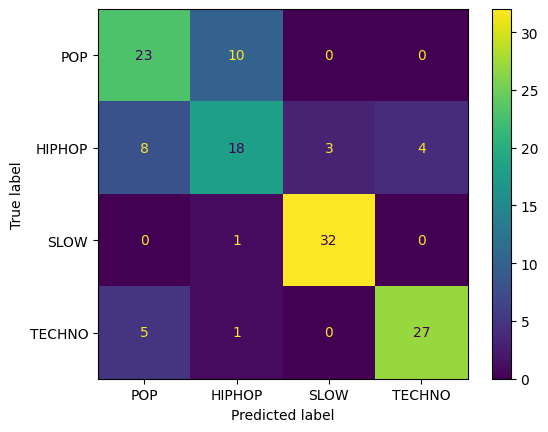

CV Accuracies Standard Deviation: 0.15264728545159
CV Accuracies Maximum: 0.9166666666666666
CV Accuracies Minimum: 0.5
CV Accuracies: [0.9166666666666666, 0.8333333333333334, 0.5, 0.5833333333333334, 0.9166666666666666, 0.8333333333333334, 0.75, 0.8333333333333334, 0.75, 0.5, 0.9166666666666666]
CV Mean Accuracy: 0.7575757575757576
CV F1: 0.7593960879806467


<Axes: ylabel='Feature'>

<Figure size 1500x1500 with 0 Axes>

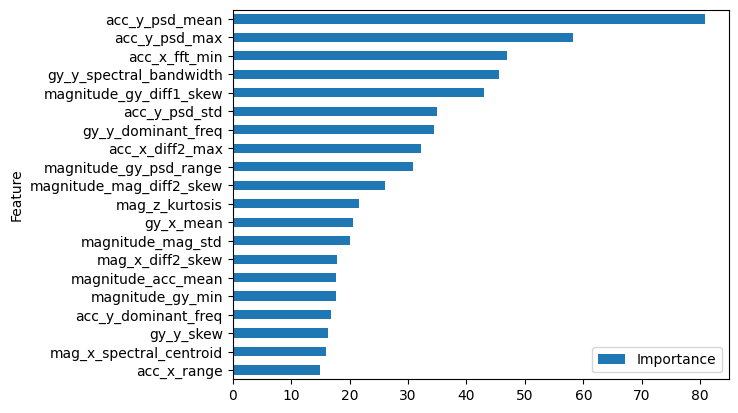

In [12]:
conf_mat = confusion_matrix(true_labels,preds_all)



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"CV Accuracies Standard Deviation: {np.std(avg_acc)}")
print(f"CV Accuracies Maximum: {np.max(avg_acc)}")
print(f"CV Accuracies Minimum: {np.min(avg_acc)}")
print(f"CV Accuracies: {avg_acc}")
print(f"CV Mean Accuracy: {accuracy_score(preds_all,true_labels)}")
print(f"CV F1: {f1_score(preds_all,true_labels,average='weighted')}")


importance_df = []
for m in models:
    df = pd.DataFrame({'Feature':m.feature_name_,'Importance':m.feature_importances_})
    importance_df.append(df)
    
importance_df = pd.concat(importance_df).groupby('Feature').mean().reset_index().sort_values('Importance')

plt.figure(figsize=(15, 15))
importance_df.tail(20).plot.barh(x='Feature', y='Importance')

### Random Forest Model

In [13]:
def objective(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 200, step=10),
        'max_depth': trial.suggest_int('max_depth', 8, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.4, 1.0, step=0.05),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    feature_cols = model_data.drop(['subject_id','label','genre_coded'],axis=1).columns
    selected_features = []
    for col in feature_cols:
        if trial.suggest_int(col, 0, 1) == 1:
            selected_features.append(col)
    if len(selected_features) == 0:
        selected_features = [feature_cols[0]]

    cv_scores = []

    for seed,val_subject in enumerate(subject_ids):

        model = RandomForestClassifier(**param_grid, n_jobs=-1,random_state=seed)

        cv_train = model_data[model_data['subject_id'] != val_subject]
        cv_test = model_data[model_data['subject_id'] == val_subject]

        X_train = cv_train[selected_features]
        X_test = cv_test[selected_features]
        y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = accuracy_score(preds, y_test)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=200)

In [15]:
#214
#selected_cols_rf = ['acc_x_fft_max','acc_x_fft_std','acc_x_fft_range','acc_x_psd_mean','acc_x_psd_std','acc_x_dominant_freq','acc_x_spectral_centroid','acc_x_spectral_rolloff','acc_y_fft_mean','acc_y_fft_min','acc_y_fft_max','acc_y_fft_std','acc_y_fft_range','acc_y_psd_mean','acc_y_dominant_freq','acc_y_spectral_entropy','acc_y_spectral_centroid','acc_z_fft_mean','acc_z_fft_max','acc_z_fft_std','acc_z_psd_min','acc_z_psd_std','acc_z_psd_range','acc_z_spectral_entropy','acc_z_spectral_centroid','acc_z_spectral_bandwidth','gy_x_psd_min','gy_x_psd_max','gy_x_psd_std','gy_x_psd_range','gy_x_dominant_freq','gy_x_spectral_bandwidth','gy_x_spectral_rolloff','gy_y_fft_min','gy_y_fft_max','gy_y_fft_std','gy_y_psd_min','gy_y_psd_max','gy_y_psd_std','gy_y_spectral_centroid','gy_y_spectral_bandwidth','gy_y_spectral_rolloff','gy_z_fft_mean','gy_z_fft_max','gy_z_psd_min','gy_z_psd_max','gy_z_psd_std','gy_z_psd_range','gy_z_spectral_entropy','gy_z_spectral_centroid','gy_z_spectral_rolloff','mag_x_fft_mean','mag_x_fft_min','mag_x_fft_range','mag_x_psd_min','mag_x_psd_std','mag_x_dominant_freq','mag_x_spectral_entropy','mag_x_spectral_bandwidth','mag_y_fft_min','mag_y_fft_max','mag_y_fft_range','mag_y_psd_min','mag_y_psd_std','mag_y_dominant_freq','mag_y_spectral_rolloff','mag_z_fft_mean','mag_z_fft_min','mag_z_fft_range','mag_z_psd_mean','mag_z_psd_min','mag_z_psd_max','mag_z_psd_range','mag_z_dominant_freq','mag_z_spectral_entropy','mag_z_spectral_bandwidth','magnitude_acc_fft_std','magnitude_acc_psd_mean','magnitude_acc_psd_max','magnitude_acc_psd_std','magnitude_acc_dominant_freq','magnitude_acc_spectral_entropy','magnitude_acc_spectral_centroid','magnitude_acc_spectral_bandwidth','magnitude_acc_spectral_rolloff','magnitude_gy_fft_min','magnitude_gy_fft_std','magnitude_gy_fft_range','magnitude_gy_psd_mean','magnitude_gy_psd_min','magnitude_gy_psd_std','magnitude_gy_psd_range','magnitude_gy_spectral_entropy','magnitude_gy_spectral_bandwidth','magnitude_mag_fft_mean','magnitude_mag_fft_min','magnitude_mag_psd_min','magnitude_mag_psd_max','magnitude_mag_spectral_entropy','magnitude_mag_spectral_bandwidth','acc_x_min','acc_x_range','acc_y_min','acc_y_skew','acc_z_std','acc_z_min','acc_z_kurtosis','gy_x_std','gy_x_min','gy_x_skew','gy_x_kurtosis','gy_y_range','gy_y_skew','gy_y_kurtosis','gy_z_std','gy_z_max','gy_z_range','gy_z_skew','mag_x_min','mag_x_max','mag_x_kurtosis','mag_y_mean','mag_y_std','mag_y_min','mag_y_range','mag_y_kurtosis','mag_z_std','mag_z_max','mag_z_range','magnitude_acc_mean','magnitude_acc_std','magnitude_acc_range','magnitude_acc_skew','magnitude_acc_kurtosis','magnitude_gy_mean','magnitude_gy_std','magnitude_gy_skew','magnitude_gy_kurtosis','magnitude_mag_mean','magnitude_mag_std','acc_x_diff1_mean','acc_x_diff1_max','acc_x_diff1_range','acc_x_diff1_skew','acc_x_diff2_min','acc_y_diff1_mean','acc_y_diff1_min','acc_y_diff1_max','acc_y_diff2_mean','acc_y_diff2_std','acc_y_diff2_max','acc_z_diff1_std','acc_z_diff1_max','acc_z_diff1_range','acc_z_diff2_mean','acc_z_diff2_max','acc_z_diff2_kurtosis','gy_x_diff1_mean','gy_x_diff1_max','gy_x_diff1_kurtosis','gy_x_diff2_mean','gy_x_diff2_max','gy_x_diff2_kurtosis','gy_y_diff1_std','gy_y_diff1_range','gy_y_diff2_min','gy_y_diff2_max','gy_y_diff2_skew','gy_z_diff1_mean','gy_z_diff1_min','gy_z_diff1_range','gy_z_diff2_mean','gy_z_diff2_std','gy_z_diff2_min','gy_z_diff2_max','gy_z_diff2_skew','gy_z_diff2_kurtosis','mag_x_diff1_mean','mag_x_diff1_skew','mag_x_diff1_kurtosis','mag_x_diff2_std','mag_x_diff2_range','mag_x_diff2_skew','mag_x_diff2_kurtosis','mag_y_diff1_min','mag_y_diff1_max','mag_y_diff1_skew','mag_y_diff1_kurtosis','mag_y_diff2_max','mag_z_diff1_mean','mag_z_diff1_std','mag_z_diff1_min','mag_z_diff1_kurtosis','mag_z_diff2_mean','mag_z_diff2_skew','magnitude_acc_diff1_mean','magnitude_acc_diff1_min','magnitude_acc_diff1_skew','magnitude_acc_diff1_kurtosis','magnitude_acc_diff2_skew','magnitude_acc_diff2_kurtosis','magnitude_gy_diff1_std','magnitude_gy_diff1_min','magnitude_gy_diff1_max','magnitude_gy_diff2_max','magnitude_gy_diff2_skew','magnitude_gy_diff2_kurtosis','magnitude_mag_diff1_mean','magnitude_mag_diff1_std','magnitude_mag_diff1_min','magnitude_mag_diff2_mean','magnitude_mag_diff2_range','magnitude_mag_diff2_skew','magnitude_mag_diff2_kurtosis']
best_params_rf = {k:v for k,v in list(study.best_params.items())[:6]}
selected_cols_rf = [col for col,select in list(study.best_params.items())[6:] if select==1]
print(study.best_value)
best_params_rf

0.7348484848484849


{'n_estimators': 100,
 'max_depth': 23,
 'min_samples_split': 9,
 'min_samples_leaf': 9,
 'max_features': 0.9,
 'bootstrap': False}

In [16]:
preds_all = []
true_labels = []
models = []
avg_acc = []

for val_subject in subject_ids:

    model = RandomForestClassifier(**best_params_rf, n_jobs=-1,random_state=904)

    cv_train = model_data[model_data['subject_id']!=val_subject]
    cv_test = model_data[model_data['subject_id']==val_subject]

    X_train = cv_train[selected_cols_rf]
    X_test = cv_test[selected_cols_rf]
    y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    preds_all.extend(preds)
    true_labels.extend(y_test)
    models.append(model)

    score = accuracy_score(preds,y_test)
    avg_acc.append(score)

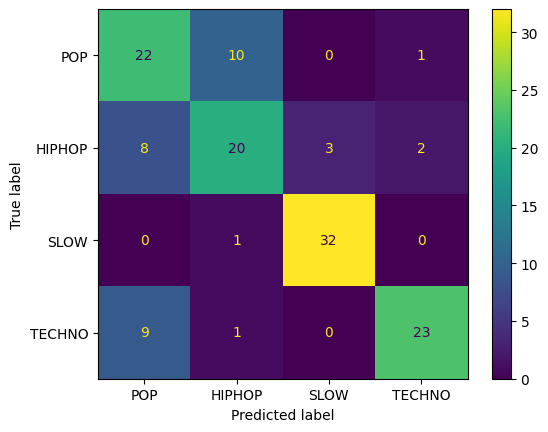

CV Accuracies Standard Deviation: 0.127218603210202
CV Accuracies Maximum: 1.0
CV Accuracies Minimum: 0.5
CV Accuracies: [1.0, 0.8333333333333334, 0.6666666666666666, 0.5833333333333334, 0.75, 0.75, 0.75, 0.75, 0.8333333333333334, 0.5, 0.6666666666666666]
CV Mean Accuracy: 0.7348484848484849
CV F1: 0.732863666188691


<Axes: ylabel='Feature'>

<Figure size 1500x1500 with 0 Axes>

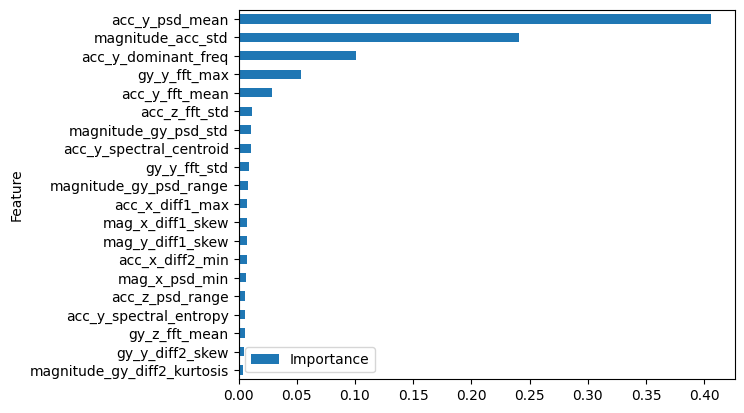

In [17]:
conf_mat = confusion_matrix(true_labels,preds_all)



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"CV Accuracies Standard Deviation: {np.std(avg_acc)}")
print(f"CV Accuracies Maximum: {np.max(avg_acc)}")
print(f"CV Accuracies Minimum: {np.min(avg_acc)}")
print(f"CV Accuracies: {avg_acc}")
print(f"CV Mean Accuracy: {accuracy_score(preds_all,true_labels)}")
print(f"CV F1: {f1_score(preds_all,true_labels,average='weighted')}")


importance_df = []
for m in models:
    df = pd.DataFrame({'Feature':m.feature_names_in_,'Importance':m.feature_importances_})
    importance_df.append(df)
    
importance_df = pd.concat(importance_df).groupby('Feature').mean().reset_index().sort_values('Importance')

plt.figure(figsize=(15, 15))
importance_df.tail(20).plot.barh(x='Feature', y='Importance')